In [1]:
import tensorflow as tf
import yaml
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

### Tacotron2


In [ ]:
tacotron2_config = AutoConfig.from_pretrained("./models/tacotron2/config.yml")
tacotron2 = TFAutoModel.from_pretrained("./models/tacotron2/model.h5",  tacotron2_config)
tacotron2_45000 = TFAutoModel.from_pretrained("./models/tacotron2/model-45000.h5",  tacotron2_config)

### MB-MelGAN

In [4]:
mb_melgan_config = AutoConfig.from_pretrained("./models/mb_melgan/config.yml")
mb_melgan = TFAutoModel.from_pretrained("./models/mb_melgan/model.h5", mb_melgan_config)
mb_melgan_200000 = TFAutoModel.from_pretrained("./models/mb_melgan/model-200000.h5", mb_melgan_config)
mb_melgan_1000000 = TFAutoModel.from_pretrained("./models/mb_melgan/model-1000000.h5", mb_melgan_config)

In [5]:
processor = AutoProcessor.from_pretrained("./models/tacotron2/processor.json")

In [6]:
def tts(input_text, text2mel_model, vocoder_model, text2mel_name, vocoder_name):
  # 文本 -> 拼音 -> phoneme -> id
  input_ids = processor.text_to_sequence(input_text, inference=True)

  # id -> 梅尔频谱
  if text2mel_name == "TACOTRON":
    _, mel_outputs, stop_token_prediction, alignment_history = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
    )
  elif text2mel_name == "FASTSPEECH2":
    mel_before, mel_outputs, duration_outputs, _, _ = text2mel_model.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
        speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        f0_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
        energy_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
    )
  else:
    raise ValueError("Only TACOTRON, FASTSPEECH2 are supported on text2mel_name")

  # 频谱 -> 音频
  if vocoder_name == "MB-MELGAN":
    # tacotron-2 generate noise in the end symtematic, let remove it :v.
    if text2mel_name == "TACOTRON":
      remove_end = 1024
    else:
      remove_end = 1
    audio = vocoder_model.inference(mel_outputs)[0, :-remove_end, 0]
  else:
    raise ValueError("Only MB_MELGAN are supported on vocoder_name")

  if text2mel_name == "TACOTRON":
    return mel_outputs.numpy(), alignment_history.numpy(), audio.numpy()
  else:
    return mel_outputs.numpy(), audio.numpy()

def visualize_attention(alignment_history):
  import matplotlib.pyplot as plt

  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111)
  ax.set_title(f'Alignment steps')
  im = ax.imshow(
      alignment_history,
      aspect='auto',
      origin='lower',
      interpolation='none')
  fig.colorbar(im, ax=ax)
  xlabel = 'Decoder timestep'
  plt.xlabel(xlabel)
  plt.ylabel('Encoder timestep')
  plt.tight_layout()
  plt.show()
  plt.close()

def visualize_mel_spectrogram(mels):
  mels = tf.reshape(mels, [-1, 80]).numpy()
  fig = plt.figure(figsize=(10, 8))
  ax1 = fig.add_subplot(311)
  ax1.set_title(f'Predicted Mel-after-Spectrogram')
  im = ax1.imshow(np.rot90(mels), aspect='auto', interpolation='none')
  fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
  plt.show()
  plt.close()

In [1]:
input_text = "这是一个端到端中文语音合成系统"

In [2]:
# setup window for tacotron2 if you want to try
# tacotron2.setup_window(win_front=5, win_back=5)
tacotron2_45000.setup_window(win_front=5, win_back=5)

NameError: name 'tacotron2_45000' is not defined

phoneme seq: sil zh e4 #0 sh iii4 #0 ^ i2 #0 g e4 #0 k ai1 #0 ^ van2 #0 d e5 #0 d uan1 #0 d ao4 #0 d uan1 #0 zh ong1 #0 ^ uen2 #0 ^ v3 #0 ^ in1 #0 h e2 #0 ch eng2 #0 x i4 #0 t ong3 #0 h a1 #0 h a1 #0 h a1 sil


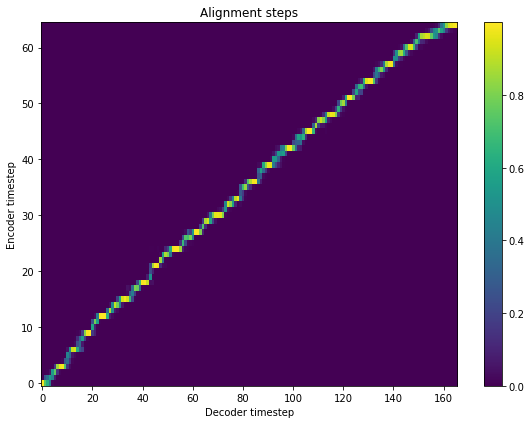

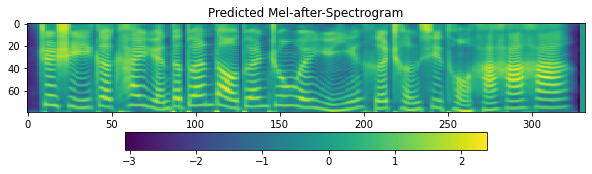

In [10]:
mels, alignment_history, audios = tts(input_text, tacotron2_45000, mb_melgan, "TACOTRON", "MB-MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=24000)

phoneme seq: sil zh e4 #0 sh iii4 #0 ^ i2 #0 g e4 #0 k ai1 #0 ^ van2 #0 d e5 #0 d uan1 #0 d ao4 #0 d uan1 #0 zh ong1 #0 ^ uen2 #0 ^ v3 #0 ^ in1 #0 h e2 #0 ch eng2 #0 x i4 #0 t ong3 #0 h a1 #0 h a1 #0 h a1 sil


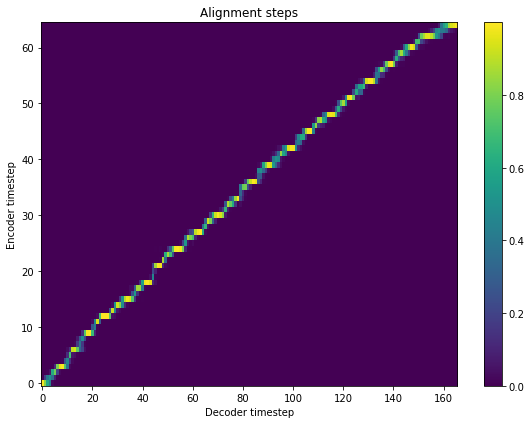

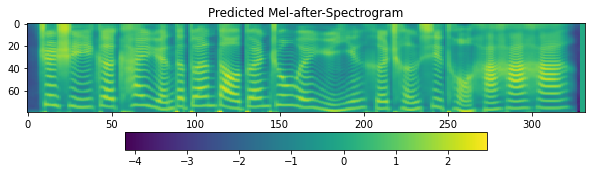

In [11]:
mels, alignment_history, audios = tts(input_text, tacotron2_45000, mb_melgan_200000, "TACOTRON", "MB-MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=24000)

phoneme seq: sil zh e4 #0 sh iii4 #0 ^ i2 #0 g e4 #0 d uan1 #0 d ao4 #0 d uan1 #0 zh ong1 #0 ^ uen2 #0 ^ v3 #0 ^ in1 #0 h e2 #0 ch eng2 #0 x i4 #0 t ong3 sil


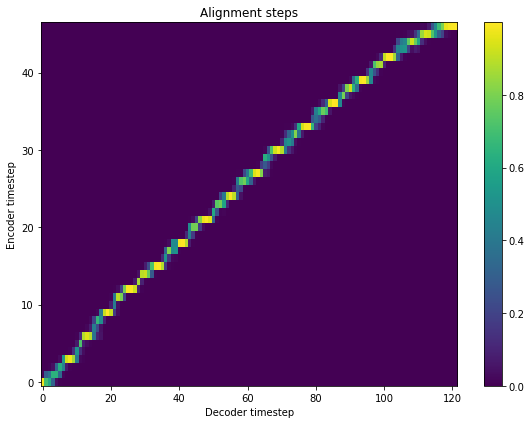

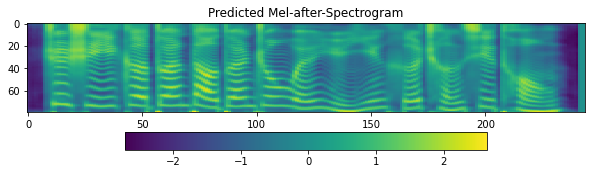

In [13]:
input_text = "这是一个端到端中文语音合成系统"
mels, alignment_history, audios = tts(input_text, tacotron2_45000, mb_melgan_1000000, "TACOTRON", "MB-MELGAN")
visualize_attention(alignment_history[0])
visualize_mel_spectrogram(mels[0])
ipd.Audio(audios, rate=24000)